In [1]:
import qiskit
from qiskit import quantum_info
from qiskit.execute_function import execute
from qiskit import BasicAer
import numpy as np
import pickle
import json
import os
from collections import Counter
from sklearn.metrics import mean_squared_error
from typing import Dict, List
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit

from qiskit import *
from qiskit import IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *

#define utility functions

def simulate(circuit: qiskit.QuantumCircuit) -> dict:
    """Simulate the circuit, give the state vector as the result."""
    backend = BasicAer.get_backend('statevector_simulator')
    job = execute(circuit, backend)
    result = job.result()
    state_vector = result.get_statevector()
    
    histogram = dict()
    for i in range(len(state_vector)):
        population = abs(state_vector[i]) ** 2
        if population > 1e-9:
            histogram[i] = population
    
    return histogram


def histogram_to_category(histogram):
    """This function take a histogram representations of circuit execution results, and process into labels as described in 
    the problem description."""
    assert abs(sum(histogram.values())-1)<1e-8
    positive=0
    for key in histogram.keys():
        digits = bin(int(key))[2:].zfill(20)
        if digits[-1]=='0':
            positive+=histogram[key]
        
    return positive


def count_gates(circuit: qiskit.QuantumCircuit) -> Dict[int, int]:
    """Returns the number of gate operations with each number of qubits."""
    counter = Counter([len(gate[1]) for gate in circuit.data])
    #feel free to comment out the following two lines. But make sure you don't have k-qubit gates in your circuit
    #for k>2
    for i in range(2,20):
        assert counter[i]==0
        
    return counter


def image_mse(image1,image2):
    # Using sklearns mean squared error:
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
    return mean_squared_error(255*image1,255*image2)

False
(28, 28)


/tmp/ipykernel_1899/1937880457.py:12: RuntimeWarning: invalid value encountered in divide
  norm_img = (img/mag_img)


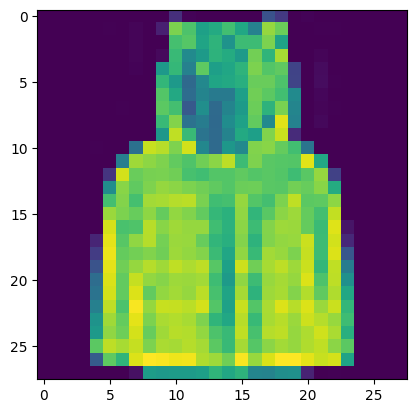

In [32]:
data_path='./data'
#load the actual hackthon data (fashion-mnist)
images=np.load(data_path+'/images.npy')
labels=np.load(data_path+'/labels.npy')
#you can visualize it
import matplotlib.pyplot as plt
index = 1900
img = images[index]
plt.imshow(img)
print(labels[index])
mag_img = sum(img**2)
norm_img = (img/mag_img)

print(img.shape)

In [25]:
image = np.array([[0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 1, 1, 1, 1, 1, 0, 0],
                  [0, 1, 1, 1, 1, 1, 1, 0],
                  [0, 1, 1, 1, 1, 1, 1, 0],
                  [0, 1, 1, 0, 1, 1, 1, 0],
                  [0, 0, 0, 1, 1, 1, 1, 0],
                  [0, 0, 0, 1, 1, 1, 1, 0],
                  [0, 0, 0, 0, 0, 0, 0, 1]])

In [26]:
# Initialize some global variable for number of qubits
data_qb = 6
anc_qb = 1
total_qb = data_qb + anc_qb

# Initialize the amplitude permutation unitary
D2n_1 = np.roll(np.identity(2**total_qb), 1, axis=1)

# def understand_np_dot_roll():
#     arr = np.random.randint(1, 9, 16).reshape(4,4) * np.identity(4)
#     print("Random matrix generated\n", arr)
#     print("Shifting image by 1 in axis=1(x-axis)\n", np.roll(arr, 1, axis=1))
#     print("Shifting image by 1 in axis=1(x-axis) and by 1 in axis=0(y-axis) \n", np.roll(arr, (1,1), axis=(0,1)))
# understand_np_dot_roll()

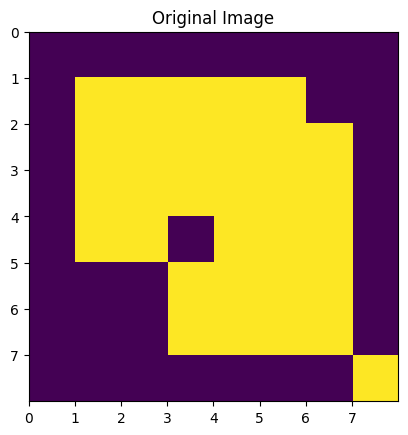

QiskitError: 'Desired statevector length not a positive power of 2.'

In [31]:
#submission to part 1, you should make this into a .py file
n=len(images)
mse=0
gatecount=0

def amplitude_encode(img_data):
    # Calculate the RMS value
    img_w, img_h = img_data.shape[0], img_data.shape[1]
    pixel_num = img_w*img_h
    rms = np.sqrt(np.sum(img_data**2))
    return (img_data/rms).reshape(pixel_num), rms, pixel_num

def plot_image(img, title: str):
    plt.title(title)
    plt.xticks(range(img.shape[0]))
    plt.yticks(range(img.shape[1]))
    plt.imshow(img, extent=[0, img.shape[0], img.shape[1], 0], cmap='viridis')
    plt.show()
    
plot_image(image, 'Original Image')

def encode(image):
    image_norm_h, rms, pixel_num = amplitude_encode(image)
    num_qubits = int(np.log2(pixel_num))
    qc_h = QuantumCircuit(num_qubits)
    qc_h.initialize(image_norm_h, range(0, num_qubits))
    return qc_h, rms

def simulate(circuit, show_histogram=True):
    backend = Aer.get_backend('statevector_simulator')
    job = execute(circuit, backend)
    result = job.result()
    statevector = result.get_statevector()
    probabilities = np.array(np.abs(statevector)**2)
    if show_histogram:
        plt.bar(range((2**circuit.num_qubits)), probabilities)
        plt.xlabel('Basis State')
        plt.ylabel('Probability')
        plt.show()
    return probabilities

def decode(probabilities, rms):
    prob_sqrt = np.sqrt(probabilities)
    reconstructed_image = prob_sqrt * rms
    return reconstructed_image

def run_part1(image):
    #encode image into a circuit
    circuit, rms =encode(image)

    #simulate circuit
    histogram=simulate(circuit)

    #reconstruct the image
    image_re=decode(histogram, rms)

    return circuit,image_re

circuit, test_image = run_part1(img)

plot_image(test_image)

In [ ]:
#how we grade your submission

n=len(images)
mse=0
gatecount=0

for data in images:
    #encode image into circuit
    circuit,image_re=run_part1(data['image'])
    
    #count the number of 2qubit gates used
    gatecount+=count_gates(circuit)[2]
    
    #calculate mse
    mse+=image_mse(data['image'],image_re)
    
#fidelity of reconstruction
f=1-mse/n
gatecount=gatecount/n

#score for part1 
print(f*(0.999**gatecount))

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices